<a href="https://colab.research.google.com/github/obifarin/the-epsilon/blob/main/03_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supplementary code for `SHAP: In the Wild`

Blog Entry: https://theepsilon.substack.com/

## Load and process data

In [ ]:
!pip install transformers shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Import necessary libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from sklearn import svm

# Use the xkcd style
plt.xkcd();

## Classifier

In [ ]:
# Load the breast_cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Select only the first 10 features for simplicity
selected_features = data.feature_names[:10]
X = X[selected_features]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train a SVM classifier
clf = svm.SVC(probability=True, random_state=42)
clf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: {:.2f}".format(auc))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

AUC: 0.99
Accuracy: 0.97


## Kernel SHAP

In [ ]:
#background dataset
X_train_summary = shap.kmeans(X_train, 10)
# Use Kernel SHAP to explain the model
explainer = shap.KernelExplainer(clf.predict_proba,
                                 X_train_summary,
                                 link='identity',
                                 seed=42)
shap_values = explainer.shap_values(X_test, seed=42)

  0%|          | 0/114 [00:00<?, ?it/s]

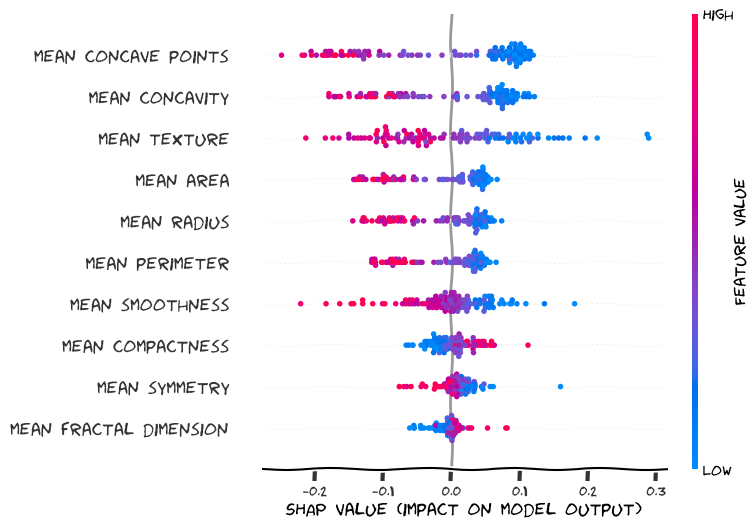

In [ ]:
# Set the color map for SHAP plots
shap.initjs()
#colors = ["#CE7870", "#EBA966", "#6E7D75", "#826A5F"]
#colors = ["#EBA966", "#6E7D75"]
#cmap = ListedColormap(colors)
shap.summary_plot(shap_values[1], X_test,
                  feature_names=data.feature_names)

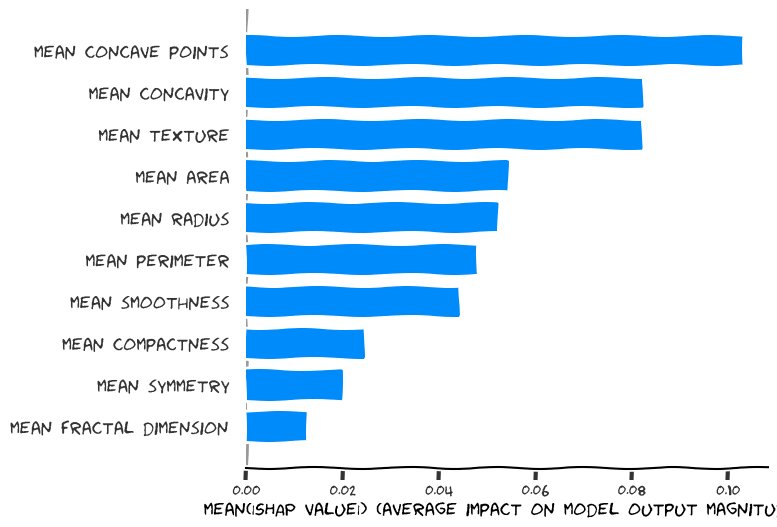

In [ ]:
shap.summary_plot(shap_values[1], X_test,
                  plot_type="bar",
                  feature_names=data.feature_names,
                  show='True')

Force Plot

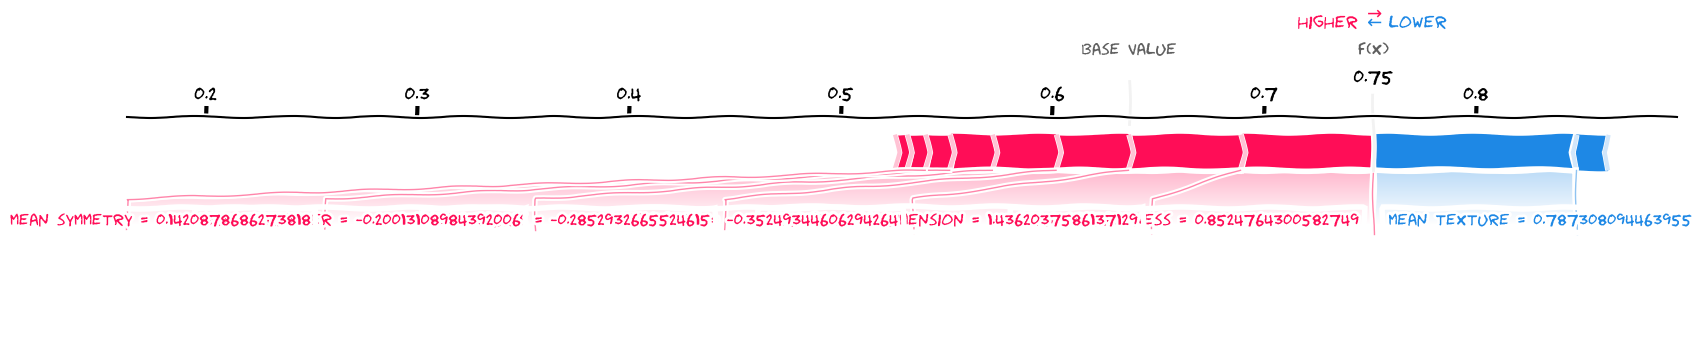

In [ ]:
shap.initjs()
sample_idx = 52 #52

# For binary classification, if explainer.expected_value is a single value
expected_value = explainer.expected_value if isinstance(explainer.expected_value, float) else explainer.expected_value[1]

# Adjust the indexing of shap_values if necessary
shap_value_to_plot = shap_values[1][sample_idx] if len(shap_values) == 2 else shap_values[sample_idx]

shap.force_plot(expected_value,
                shap_value_to_plot,
                X_test[sample_idx],
                feature_names=selected_features,
                matplotlib=True)


Waterfall Plot

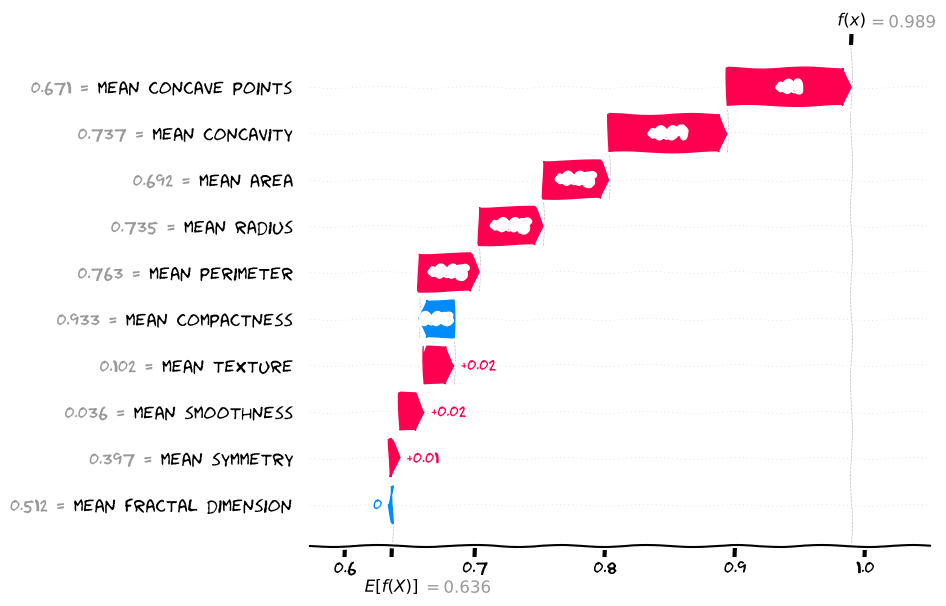

In [ ]:
# Waterfall plot
sample_index = 35 # Choose the index of the instance you want to explain
shap_values_obj = shap.Explanation(values=shap_values[1][sample_index],
                                   base_values=explainer.expected_value[1],
                                   data=X_test[sample_index],
                                   feature_names=selected_features)

shap.waterfall_plot(shap_values_obj)

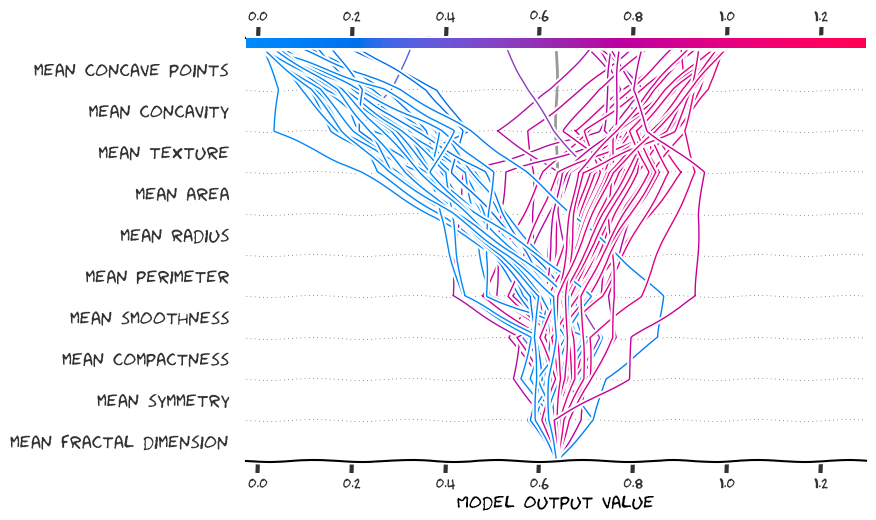

In [ ]:
# create a shap decision plot
shap.decision_plot(explainer.expected_value[1],
                   shap_values[1],
                   feature_names=selected_features,
                   link='identity')

## Text Generation XAI

Here, we will uses a text generation model, a transformer to complete a sentence, followed by XAI by SHAP.

In [ ]:
#pip install transformers shap

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap

In [ ]:
# For GPT-Neo, you can choose between "EleutherAI/gpt-neo-1.3B" and "EleutherAI/gpt-neo-2.7B"
# For GPT-J, use "EleutherAI/gpt-j-6B"
model_name = "gpt2"  # Replace with gpt2

In [ ]:

# Load tokenizer and model from Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Set model decoder to true
# GPT is a decoder-only model
model.config.is_decoder = True
# We set configurations for the output text generation
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0,  # to turn off randomness
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}

In [ ]:
explainer = shap.Explainer(model, tokenizer)

In [ ]:
input_sentence = ["Hot days are not good for your health. The best way to prevent your body"]
shap_values = explainer(input_sentence)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.64s/it]               


We can now evaluate how each input token influences the output token. A "red" color signifies a positive influence, while "blue" indicates a negative impact. The depth of the color reflects the magnitude of the contribution.

`Note: The base value represents the model's output when all input text is concealed. Conversely, f_outputclass(inputs) is the model's output to the complete, unaltered input. The SHAP values  show, through it additivity feature, the manner in which unmasking each word changes the model's output from the base value (with all input hidden) to the eventual predicted value`


In [ ]:
shap.plots.text(shap_values)

What input token contributes most the output `selected.`

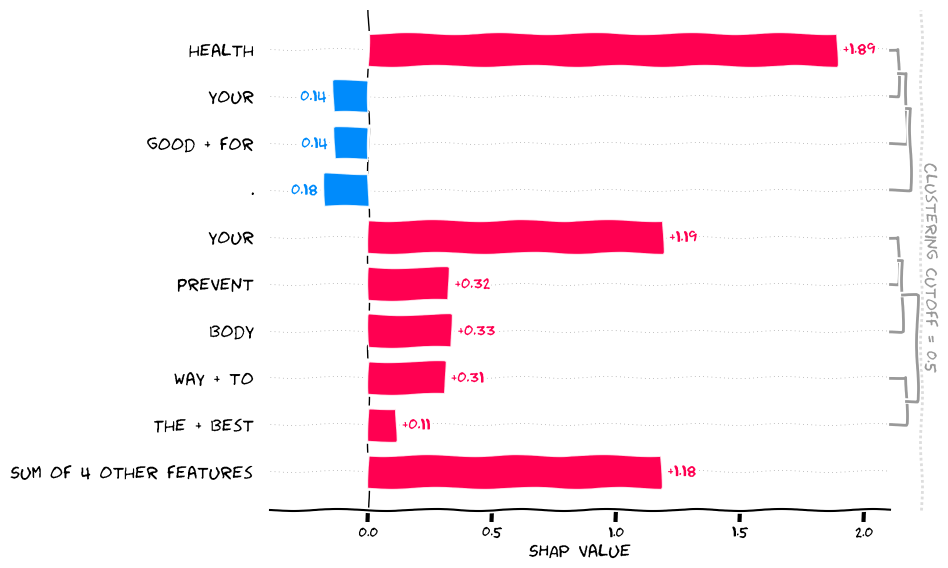

In [ ]:
shap.plots.bar(shap_values[0, :, "sick"])

Another example:

In [ ]:
input_sentence = ["You should sleep for eight hours. So,"]
shap_values = explainer(input_sentence)

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
shap.plots.text(shap_values)

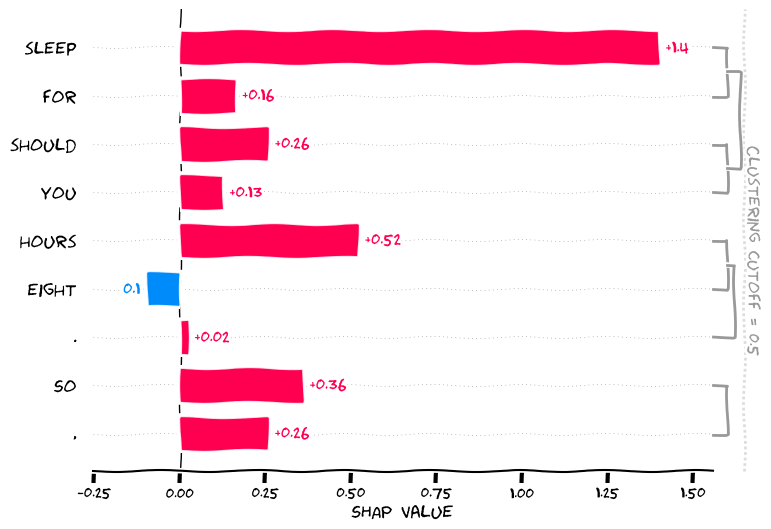

In [ ]:
shap.plots.bar(shap_values[0, :, "feeling"])